In [1]:
#Note: Please run pip install keras, and pip install tensoflow to use the libraries utilized in this code
#Documentation to Keras API
import matplotlib.pyplot as plt
import sys, os, re, csv, codecs, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Activation, Dense, Dropout, Embedding, Input, LSTM
from keras.layers import Bidirectional,Conv1D, GlobalMaxPool1D
from keras import initializers, constraints, regularizers, optimizers, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Reading in data
train = pd.read_csv('train.csv')

In [3]:
#Showing the head of data to take a peek
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
#Setting up the variables
categories=["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
y=train[categories].values
train_set=train["comment_text"]
#Filling in empty fields
train_set.fillna(' ')


0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [8]:
#Hyperparameters
maxfeatures = 25000
maxlen=250
dropout_rate=0.2
batch_size = 32
epochs = 2
embed_d = 128

In [14]:
#Tokenizing sentences using the default tokenizer provided by kears
tokenizer = Tokenizer(num_words=maxfeatures)
tokenizer.fit_on_texts(list(train_set))
tokenized_train = tokenizer.texts_to_sequences(train_set)

In [16]:
X_train = pad_sequences(tokenized_train, maxlen)

In [17]:
length_of_seq = [len(seq) for seq in tokenized_train]

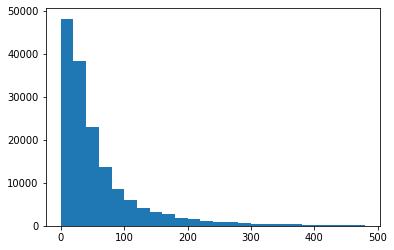

In [18]:
#Take a look at the average length of a sequence
plt.hist(length_of_seq,bins = np.arange(0,500,20))
plt.show()

In [22]:
#Layers: Embedding into bidirecitonal LSTM->Convousion 1 D->Max pooling->dropout->ReLu->dropout->sigmoid
def lstm_cnn():
    inputt = Input(shape=(maxlen, ))
    x = Embedding(maxfeatures, embed_d)(inputt)
    #https://keras.io/api/layers/recurrent_layers/bidirectional/
    #https://keras.io/api/layers/recurrent_layers/lstm/
    x = Bidirectional(LSTM(60, return_sequences=True,name='lstm'))(x)
    #https://keras.io/api/layers/convolution_layers/convolution1d/
    x = Conv1D(64, 4,padding ="valid",kernel_initializer = "glorot_uniform")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(60,activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(6,activation="sigmoid")(x)
    model=Model(inputt,x)
    #https://keras.io/api/models/model_training_apis/#compile-method
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [23]:
#Layers: Embedding into LSTM ->Max pooling->dropout->ReLu->dropout->sigmoid
def lstm():
    inputt = Input(shape=(maxlen, ))
    x = Embedding(maxfeatures, embed_d)(inputt)
    #https://keras.io/api/layers/recurrent_layers/lstm/
    x = LSTM(60, return_sequences=True,name='lstm')(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(60,activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(6,activation="sigmoid")(x)
    model=Model(inputt,x)
    #https://keras.io/api/models/model_training_apis/#compile-method
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [24]:
#Declaring the two models
model1=lstm_cnn()
model2=lstm()


In [25]:
#Early stopping and training the first model (biLSTM-CNN)
file_path1="best_weights_model1.hdf5"
chkpt1 = ModelCheckpoint(file_path1, 'val_loss', verbose=1, save_best_only=True, mode='min')
early1 = EarlyStopping("val_loss", mode="min", patience=15)
callbacks1 = [chkpt1, early1] 
#please note that validation split is similar to the train test split we used normally
#so we save 10% of the data as validation data
#https://keras.io/api/models/model_training_apis/#fit-method
model1.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks1)

model1.load_weights(file_path1)


Epoch 1/2
4488/4488 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9592
Epoch 00001: val_loss improved from inf to 0.04924, saving model to best_weights_model1.hdf5
4488/4488 [==============================] - 704s 157ms/step - loss: 0.0601 - accuracy: 0.9592 - val_loss: 0.0492 - val_accuracy: 0.9935
Epoch 2/2
4488/4488 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9760
Epoch 00002: val_loss improved from 0.04924 to 0.04724, saving model to best_weights_model1.hdf5
4488/4488 [==============================] - 674s 150ms/step - loss: 0.0423 - accuracy: 0.9760 - val_loss: 0.0472 - val_accuracy: 0.9936


In [26]:
#Early Stopping and training our second model (LSTM)
file_path2="best_weights_model2.hdf5"
chkpt2 = ModelCheckpoint(file_path2,'val_loss',verbose=1, save_best_only=True, mode='min')
early2 = EarlyStopping("val_loss", mode="min", patience=15)
callbacks2 = [chkpt2, early2] 
#please note that validation split is similar to the train test split we used normally
#so we save 10% of the data as validation data
#https://keras.io/api/models/model_training_apis/#fit-method
model2.fit(X_train, y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=callbacks2)

model2.load_weights(file_path2)


Epoch 1/2
4488/4488 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9550
Epoch 00001: val_loss improved from inf to 0.05058, saving model to best_weights_model2.hdf5
4488/4488 [==============================] - 449s 100ms/step - loss: 0.0715 - accuracy: 0.9550 - val_loss: 0.0506 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9884
Epoch 00002: val_loss improved from 0.05058 to 0.04849, saving model to best_weights_model2.hdf5
4488/4488 [==============================] - 457s 102ms/step - loss: 0.0450 - accuracy: 0.9884 - val_loss: 0.0485 - val_accuracy: 0.9940


In [27]:
#This summarizes the layers and the output dimensions of model1
model1.summary()  

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 250, 128)          3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 120)          90720     
_________________________________________________________________
conv1d (Conv1D)              (None, 247, 64)           30784     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 60)               

In [28]:
#This summarizes the layers and the output dimensions of model1
model2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 250, 128)          3200000   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 60)           45360     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 60)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)               